<a href="https://colab.research.google.com/github/sispo3314/AI_study/blob/main/mHealth/mHealth_transformer%2Bcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import re
from scipy import stats

from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Conv1D, MaxPooling1D, GlobalAveragePooling1D,
    BatchNormalization, Dropout, LayerNormalization, MultiHeadAttention,
    Add, Flatten
)

In [3]:
DATA_DIR = "/content/drive/MyDrive/datasets/MHEALTHDATASET"
COLS = [
    "chest_acc_x", "chest_acc_y", "chest_acc_z", "ecg_lead1", "ecg_lead2",
    "lankle_acc_x", "lankle_acc_y", "lankle_acc_z", "lankle_gyro_x",
    "lankle_gyro_y", "lankle_gyro_z", "lankle_mag_x", "lankle_mag_y",
    "lankle_mag_z", "rarm_acc_x", "rarm_acc_y", "rarm_acc_z",
    "rarm_gyro_x", "rarm_gyro_y", "rarm_gyro_z", "rarm_mag_x",
    "rarm_mag_y", "rarm_mag_z", "label"
]

In [4]:
ACTIVITY_MAP = {
    0: "null", 1: "standing", 2: "sitting", 3: "lying", 4: "walking",
    5: "climbing_stairs", 6: "waist_bends_forward", 7: "frontal_arm_raise",
    8: "knees_bending", 9: "cycling", 10: "jogging", 11: "running",
    12: "jump_front_back"
}
SAMPLING_RATE = 50

In [5]:
WINDOW_SECONDS = 2.5 # 2.5초 길이의 윈도우
WINDOW_SIZE = int(WINDOW_SECONDS * SAMPLING_RATE)
STEP = WINDOW_SIZE // 2

In [6]:
FEATURES_COLS = [c for c in COLS if c != "label"]
NUM_FEATURES = len(FEATURES_COLS)
NUM_CLASSES = 12

In [7]:
#데이터 로드 및 전처리

In [8]:
files=sorted(glob.glob(os.path.join(DATA_DIR, "mHealth_subject*.log")))

In [9]:
dfs=[]
for f in files:
    tmp = pd.read_csv(f, delim_whitespace=True, header=None)
    tmp.columns = COLS
    tmp["subject"] = int(re.search(r"subject(\d+)", f).group(1))
    dfs.append(tmp)

/tmp/ipython-input-3411836070.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  tmp = pd.read_csv(f, delim_whitespace=True, header=None)
/tmp/ipython-input-3411836070.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  tmp = pd.read_csv(f, delim_whitespace=True, header=None)
/tmp/ipython-input-3411836070.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  tmp = pd.read_csv(f, delim_whitespace=True, header=None)
/tmp/ipython-input-3411836070.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  tmp = pd.read_csv(f, delim_whitespace=True, header=None)
/tmp/ipython-input-3411836070.py:3: FutureWarning: T

In [10]:
df_raw=pd.concat(dfs, axis=0, ignore_index=True)
df_raw.shape

(1215745, 25)

In [11]:
#null (레이블 0) 데이터 제외
df_activity=df_raw[df_raw["label"]!=0].copy()

In [12]:
df_activity['label'] = df_activity['label'] - 1

In [13]:
df_activity.shape

(343195, 25)

In [14]:
sorted(df_activity['label'].unique())

[np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6),
 np.int64(7),
 np.int64(8),
 np.int64(9),
 np.int64(10),
 np.int64(11)]

In [15]:
#스케일링
#Train, test 분리 및 스케일링
train_subjects=[1, 2, 3, 4, 5, 6]
val_subjects=[7, 8]
test_subjects=[9, 10]

train_data=df_activity[df_activity['subject'].isin(train_subjects)].copy()
val_data=df_activity[df_activity['subject'].isin(val_subjects)].copy()
test_data=df_activity[df_activity['subject'].isin(test_subjects)].copy()

print(f"Train 데이터 shape: {train_data.shape} (Subjects: {train_subjects})")
print(f"Validation 데이터 shape: {val_data.shape} (Subjects: {val_subjects})")
print(f"Test 데이터 shape: {test_data.shape} (Subjects: {test_subjects})")

Train 데이터 shape: (207566, 25) (Subjects: [1, 2, 3, 4, 5, 6])
Validation 데이터 shape: (67585, 25) (Subjects: [7, 8])
Test 데이터 shape: (68044, 25) (Subjects: [9, 10])


In [16]:
#StandardScaler 적용
scaler=StandardScaler()
#scaler를 train data로만 fit 한다.
scaler.fit(train_data[FEATURES_COLS])

StandardScaler()

In [17]:
#스케일러 적용
train_data.loc[:, FEATURES_COLS] = scaler.transform(train_data[FEATURES_COLS])
val_data.loc[:, FEATURES_COLS] = scaler.transform(val_data[FEATURES_COLS])
test_data.loc[:, FEATURES_COLS] = scaler.transform(test_data[FEATURES_COLS])

In [39]:
def create_windows(data, window_size, step, features_cols, label_col='label'):
    X, y = [], []
    for subject, g in data.groupby('subject'):
        g = g.sort_index()
        segment = g[features_cols].values
        labels  = g[label_col].values
        n = len(g)
        for i in range(0, n - window_size + 1, step):
            win_y = labels[i : i + window_size]
            #최빈값을 라벨로
            win_label = stats.mode(win_y, keepdims=True)[0][0]
            X.append(segment[i : i + window_size])
            y.append(win_label)
    return np.array(X), np.array(y)

In [40]:
X_train, y_train = create_windows(train_data, WINDOW_SIZE, STEP, FEATURES_COLS)
X_val, y_val = create_windows(val_data, WINDOW_SIZE, STEP, FEATURES_COLS)
X_test, y_test = create_windows(test_data, WINDOW_SIZE, STEP, FEATURES_COLS)

print(f"X_train shape: {X_train.shape} | y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape} | y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape} | y_test shape: {y_test.shape}")

X_train shape: (3339, 125, 23) | y_train shape: (3339,)
X_val shape: (1087, 125, 23) | y_val shape: (1087,)
X_test shape: (1095, 125, 23) | y_test shape: (1095,)


### Transformer+CNN

In [41]:
from tensorflow.keras.layers import Embedding, Layer

class PositionalEmbedding(Layer):
    def __init__(self, seq_len, d_model, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.pos_emb = Embedding(input_dim=seq_len, output_dim=d_model)
        self.seq_len = seq_len

    def call(self, x):
        positions = tf.range(start=0, limit=self.seq_len, delta=1)
        embedded_positions = self.pos_emb(positions)
        return x + embedded_positions

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            'seq_len': self.seq_len,
            'd_model': self.d_model,
        })
        return config

In [42]:
def transformer_encoder_block(inputs, d_model, num_heads, ff_dim, dropout=0.1):
  #멀티헤드 어텐션
  attn_input=LayerNormalization(epsilon=1e-6)(inputs)
  attention=MultiHeadAttention(
      num_heads=num_heads, key_dim=d_model//num_heads
  )(attn_input, attn_input)
  attention=Dropout(dropout)(attention)
  attn_output=Add()([inputs, attention])

  #피드포워드 네트워크
  ffn_input=LayerNormalization(epsilon=1e-6)(attn_output)
  ffn_output=Dense(ff_dim, activation="relu")(ffn_input)
  ffn_output=Dropout(dropout)(ffn_output)
  ffn_output=Dense(d_model)(ffn_output)

  return Add()([attn_output, ffn_output])

In [43]:
def build_cnn_transformer(input_shape, num_classes, d_model=64, num_heads=4, ff_dim=128, num_transformer_blocks=2):
  inputs=Input(shape=input_shape)

  x=Conv1D(filters=32, kernel_size=5, activation='relu', padding="same")(inputs)
  x=BatchNormalization()(x)
  x=MaxPooling1D(pool_size=2)(x)

  x=Conv1D(filters=d_model, kernel_size=5, activation="relu", padding="same")(x)
  x=BatchNormalization()(x)
  x=MaxPooling1D(pool_size=2)(x)

  seq_len_after_cnn = x.shape[1]
  x = PositionalEmbedding(seq_len=seq_len_after_cnn, d_model=d_model)(x)
  x = Dropout(0.1)(x)

  for _ in range(num_transformer_blocks):
    x=transformer_encoder_block(x, d_model, num_heads, ff_dim)

  x=GlobalAveragePooling1D()(x)
  x=Dropout(0.3)(x)
  x=Dense(64, activation="relu")(x)
  x=Dropout(0.3)(x)
  outputs=Dense(num_classes, activation="softmax")(x)

  model=Model(inputs=inputs, outputs=outputs)
  return model

In [44]:
#모델 생성
model_input_shape = (WINDOW_SIZE, NUM_FEATURES)

model = build_cnn_transformer(
    model_input_shape,
    num_classes=NUM_CLASSES,
    d_model=64,
    num_heads=4,
    ff_dim=128,
    num_transformer_blocks=2
)

In [45]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 125, 23)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 125, 32)   │      3,712 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 32)   │        128 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 62, 32)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 62, 64)    │     10,304 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 64)    │        256 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 31, 64)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 31, 64)    │      1,984 │ max_pooling1d_3[… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 31, 64)    │          0 │ positional_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 64)    │        128 │ dropout_8[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 64)    │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 31, 64)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 31, 64)    │          0 │ dropout_8[0][0],  │
│                     │                   │            │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 64)    │        128 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 31, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 31, 128)   │          0 │ dense_6[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 31, 64)    │      8,256 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 31, 64)    │          0 │ add_4[0][0],      │
│                     │                   │            │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 88,268 (344.80 KB)

 Trainable params: 88,076 (344.05 KB)

 Non-trainable params: 192 (768.00 B)

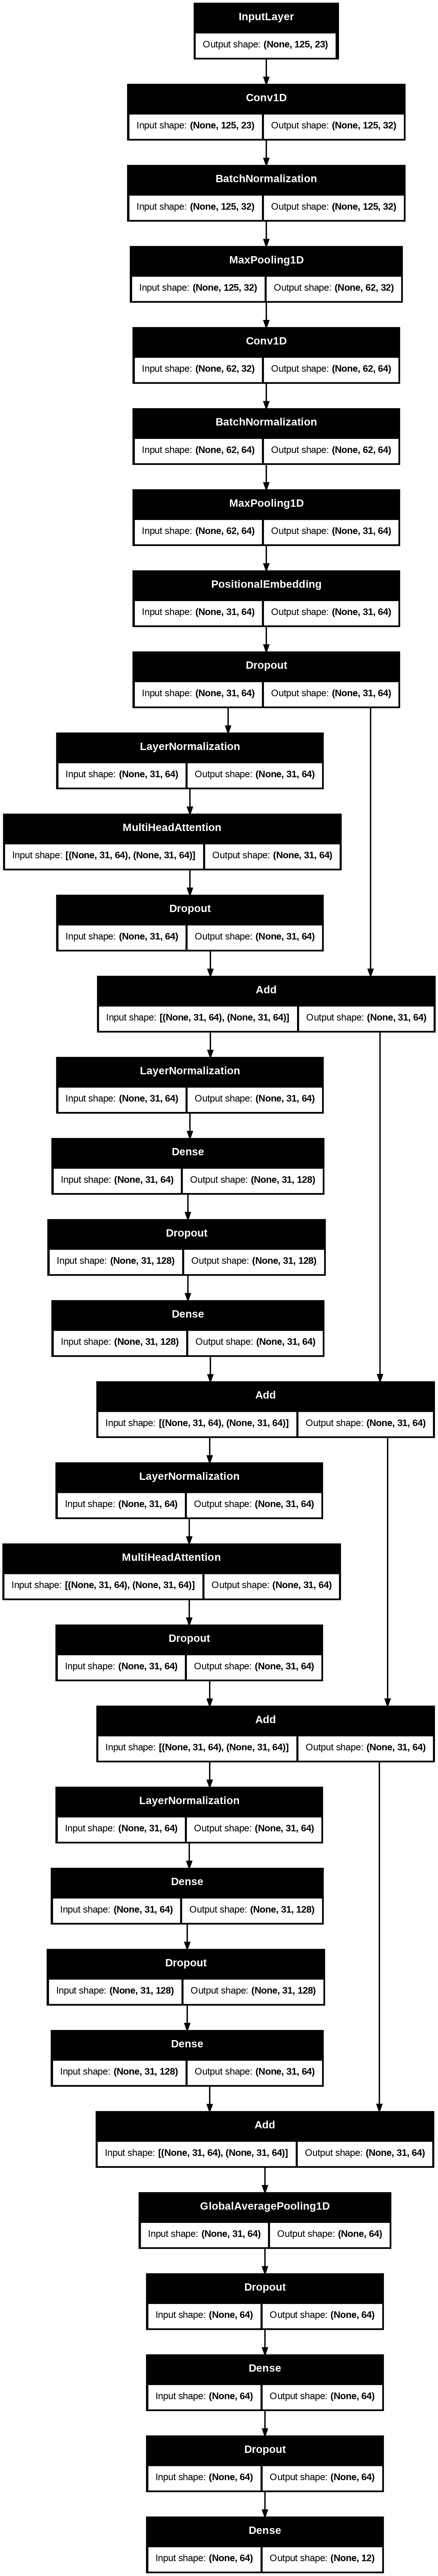

In [46]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [47]:
#모델 학습
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6
    )
]

history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 116ms/step - accuracy: 0.5163 - loss: 1.5256 - val_accuracy: 0.6283 - val_loss: 1.3006 - learning_rate: 0.0010
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9385 - loss: 0.1993 - val_accuracy: 0.8031 - val_loss: 0.7259 - learning_rate: 0.0010
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9643 - loss: 0.1083 - val_accuracy: 0.8970 - val_loss: 0.3760 - learning_rate: 0.0010
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9832 - loss: 0.0583 - val_accuracy: 0.8178 - val_loss: 0.5348 - learning_rate: 0.0010
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9878 - loss: 0.0454 - val_accuracy: 0.8832 - val_loss: 0.5011 - learning_rate: 0.0010
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9816 - loss: 0.0608 - val_accuracy: 0.8556 - val_loss: 0.5959 - learning_rate: 0.0010
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9808 - loss: 0.06

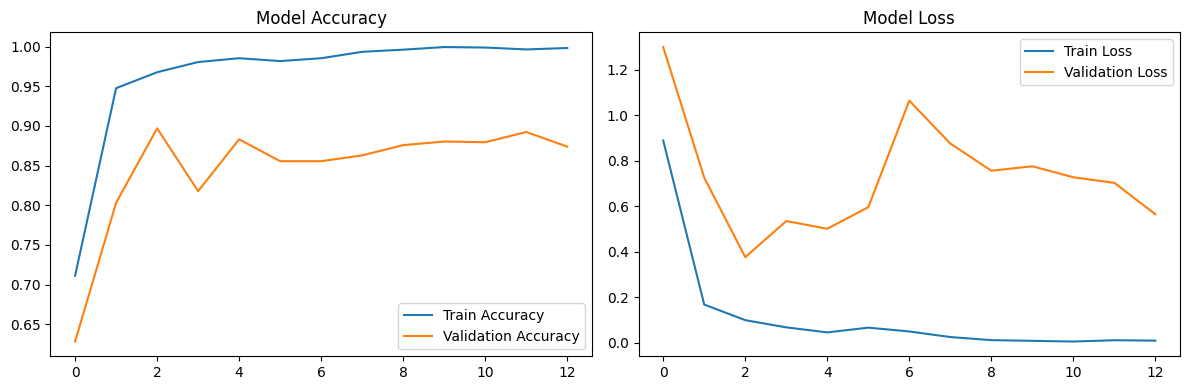

In [48]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [49]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step


In [50]:
target_names = [v for k, v in ACTIVITY_MAP.items() if k != 0]

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred_classes, target_names=target_names))


--- Classification Report ---
                     precision    recall  f1-score   support

           standing       1.00      1.00      1.00        99
            sitting       0.99      1.00      0.99        99
              lying       1.00      0.99      0.99        99
            walking       1.00      0.61      0.75        99
    climbing_stairs       0.71      0.98      0.82        98
waist_bends_forward       0.64      1.00      0.78        86
  frontal_arm_raise       1.00      1.00      1.00        90
      knees_bending       0.96      0.47      0.63        95
            cycling       0.99      1.00      0.99        99
            jogging       1.00      1.00      1.00        99
            running       1.00      1.00      1.00        99
    jump_front_back       1.00      1.00      1.00        33

           accuracy                           0.92      1095
          macro avg       0.94      0.92      0.91      1095
       weighted avg       0.94      0.92      0.91  


--- Confusion Matrix ---


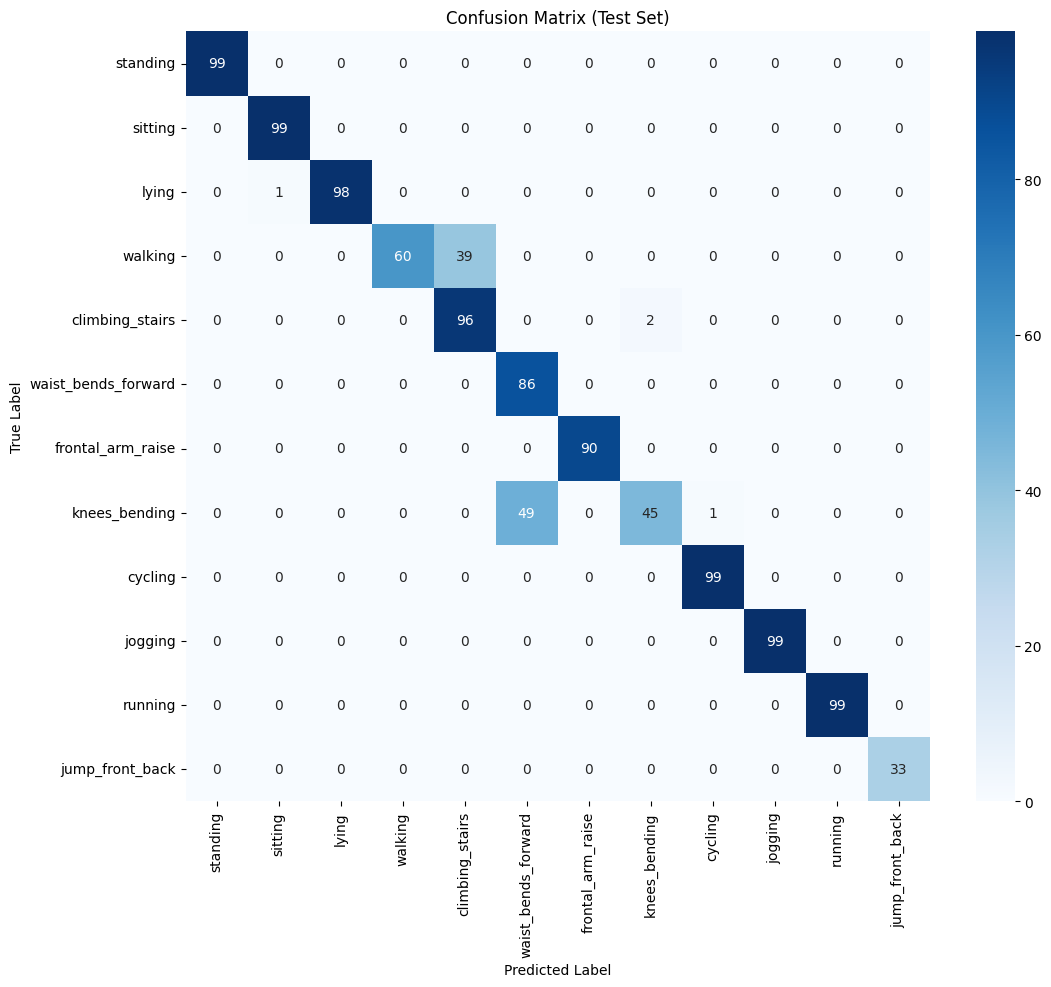

In [51]:
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix (Test Set)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [52]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9704 - loss: 0.1182

Test Accuracy: 0.9160
Test Loss: 0.3823
